In [1]:
# load packages
import os
import shutil
from tqdm import tqdm
import csv
import requests
import sqlite3
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(
    "ignore", category=UserWarning, module="matplotlib.font_manager"
)

## Get in-situ data from OpenAQ API

In [2]:
# list of cities
csv_file_path = "data/CAMS_locations_v1.csv"

# local database file
db_file = "data/01_openaq_station-data.db"

pollutants = ["o3", "no2", "so2", "pm10", "pm25"]
pollutant_labels = ["$O_3$", "$NO_2$", "$SO_2$", "$PM_{10}$", "$PM_{2.5}$"]

# API query parameters
end_date = datetime.now()
start_date = end_date - timedelta(days=7)

# plot directories
map_directory = "figures/01/maps"
ts_directory = "figures/01/city_time_series"
# remove old plots
if os.path.exists(map_directory):
    shutil.rmtree(map_directory)
if os.path.exists(ts_directory):
    shutil.rmtree(ts_directory)
os.makedirs(map_directory)
os.makedirs(ts_directory)

### fetch data and store in local database
query data for the last week for each city via the openaq API and store all results
in local SQL database for further analysis

In [3]:
if os.path.exists(db_file):
    os.remove(db_file)

# create a connection to the SQLite database
conn = sqlite3.connect(db_file)
cursor = conn.cursor()

# create tables for each pollutant
for parameter in pollutants:
    cursor.execute(
        f"""
    CREATE TABLE IF NOT EXISTS {parameter} (
        location_id TEXT,
        location_name TEXT,
        city TEXT,
        country TEXT,
        latitude REAL,
        longitude REAL,
        date_utc TEXT,
        value REAL
    )
    """
    )
conn.commit()


def call_openaq_api(latitude, longitude):
    url = "https://api.openaq.org/v2/measurements"
    all_results = []
    page = 1
    while True:
        # print(f'Fetching data from page {page}...')
        params = {
            "coordinates": f"{latitude},{longitude}",
            "date_from": start_date.strftime("%Y-%m-%dT%H:%M:%SZ"),
            "date_to": end_date.strftime("%Y-%m-%dT%H:%M:%SZ"),
            "limit": 100000,
            "radius": "25000",  # 25 km radius
            "order_by": "datetime",
            "page": page,
            "offset": "0",
        }
        # filter for multiple pollutants by appending them to the URL
        for parameter in pollutants:
            params[f"parameter[]"] = parameter
        # personal API key
        headers = {
            "X-API-Key": "e468891dfc9883eda10e5d94b6cef19c8dbf30fab53ddc3a910ce59fc0ce9e6f"
        }
        response = requests.get(url, params=params, headers=headers)
        data = response.json()
        results = data.get("results", [])
        # print(len(results))

        all_results.extend(results)

        # Check if there are more pages to fetch
        if len(results) < params["limit"]:
            break

        page += 1
    return all_results


# get city list from CSV file
with open(csv_file_path, mode="r", newline="") as csvfile:
    reader = csv.DictReader(csvfile)
    city_rows = list(reader)

for row in tqdm(city_rows[:], desc="Fetching data for cities"):
    city_id = row["id"]
    city_name = row["city"]
    country = row["country"]
    latitude = row["latitude"]
    longitude = row["longitude"]

    # print(f'fetching data for {city_name}, {country}, {latitude}, {longitude}...')

    # call the OpenAQ API for the current city's location
    results = call_openaq_api(latitude, longitude)

    # process and insert the results into the database
    for result in results:
        parameter = result["parameter"]
        if parameter in pollutants:
            location_id = result["locationId"]
            location_name = result["location"]
            date_utc = result["date"]["utc"]
            value = result["value"]
            coordinates = result["coordinates"]

            # insert data into the respective table
            cursor.execute(
                f"""
            INSERT INTO {parameter} (location_id, location_name, city, country, latitude, longitude, date_utc, value)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?)
            """,
                (
                    location_id,
                    location_name,
                    city_name,
                    country,
                    coordinates["latitude"],
                    coordinates["longitude"],
                    date_utc,
                    value,
                ),
            )
    conn.commit()

conn.close()

Fetching data for cities: 100%|██████████| 153/153 [03:08<00:00,  1.23s/it]


### load data from local database

In [4]:
# read the data into a pandas DataFrame for further analysis
def get_data(parameter):
    conn = sqlite3.connect(db_file)
    df = pd.read_sql_query(f"SELECT * FROM {parameter}", conn)
    conn.close()
    return df


# load data for each parameter
data = {parameter: get_data(parameter) for parameter in pollutants}

### overview maps of available data
let's start with some maps for each pollutant to show for which cities we actually have data available

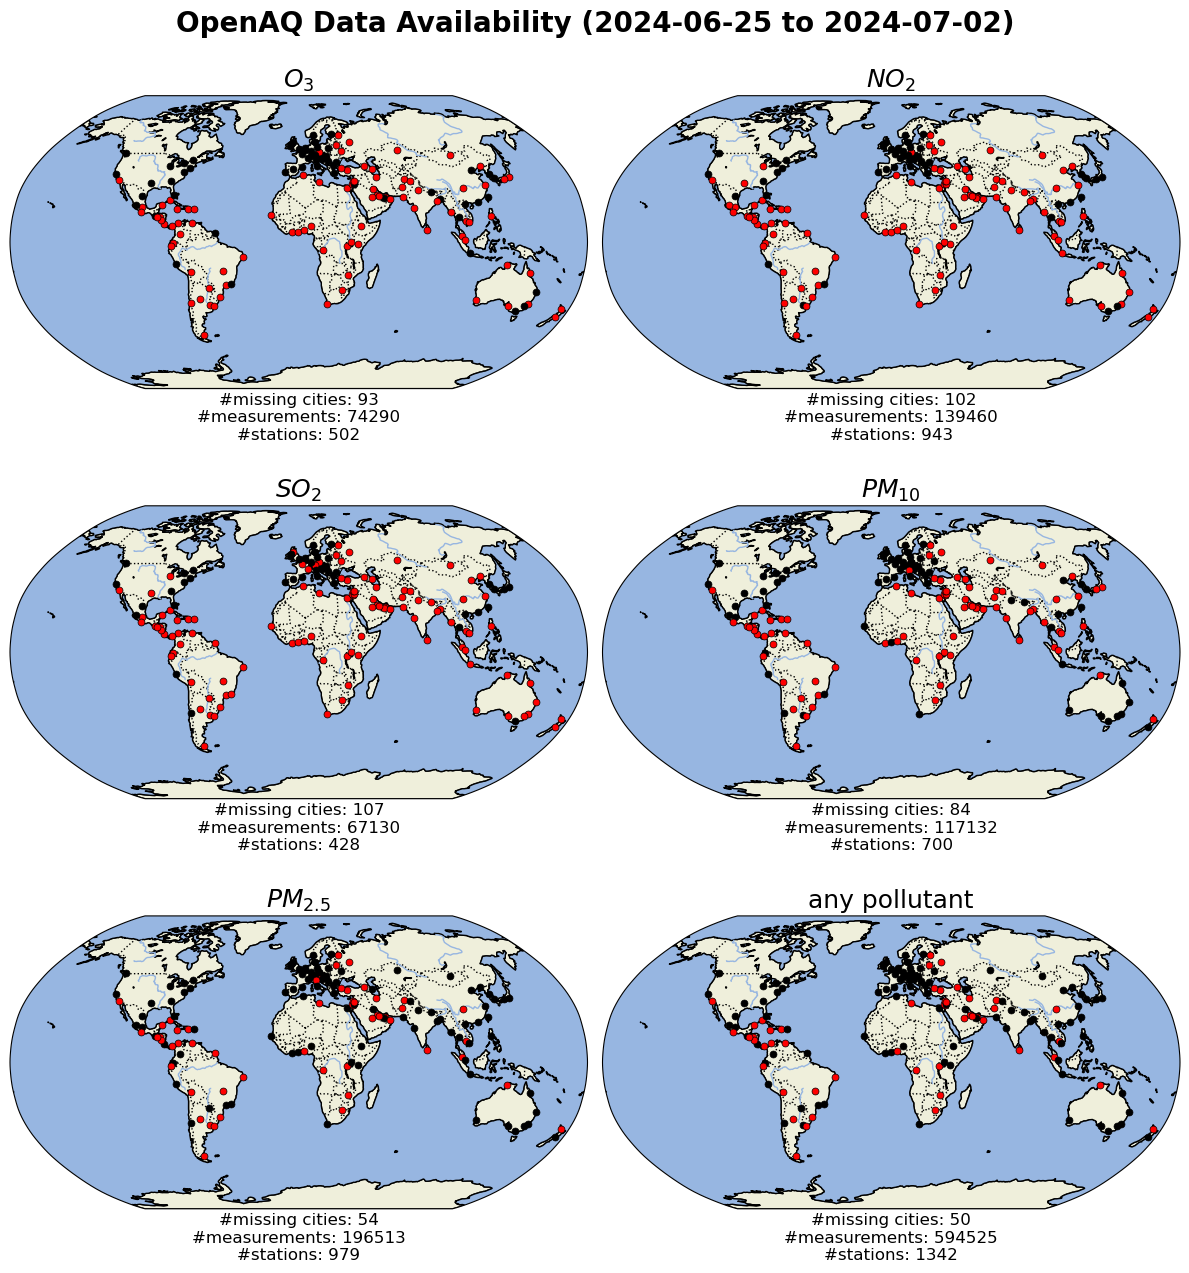

In [5]:
def check_data_availability(city, pollutant_data):
    return not pollutant_data[pollutant_data["city"] == city].empty


def check_any_data_availability(city):
    for parameter in pollutants:
        if check_data_availability(city, data[parameter]):
            return True
    return False


date_range_str = f'{start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")}'

# create global maps with cartopy
fig, axes = plt.subplots(
    nrows=3, ncols=2, figsize=(12, 13), subplot_kw={"projection": ccrs.Robinson()}
)
axes = axes.flatten()

available_color = "black"
not_available_color = "red"
edge_color = "black"

# one map for each pollutant
for i, parameter in enumerate(pollutants):
    ax = axes[i]
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    ax.add_feature(cfeature.LAND, edgecolor="black")
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAKES, edgecolor="black")
    ax.add_feature(cfeature.RIVERS)

    missing_locations = 0
    available_measurements = 0
    unique_stations = set()

    for row in city_rows:
        city_name = row["city"]
        latitude = float(row["latitude"])
        longitude = float(row["longitude"])
        if check_data_availability(city_name, data[parameter]):
            ax.plot(
                longitude,
                latitude,
                marker="o",
                color=available_color,
                markersize=5,
                markeredgecolor=edge_color,
                markeredgewidth=0.5,
                transform=ccrs.PlateCarree(),
            )
            available_measurements += len(
                data[parameter][data[parameter]["city"] == city_name]
            )
            unique_stations.update(
                data[parameter][data[parameter]["city"] == city_name]["location_name"]
            )
        else:
            ax.plot(
                longitude,
                latitude,
                marker="o",
                color=not_available_color,
                markersize=5,
                markeredgecolor=edge_color,
                markeredgewidth=0.5,
                transform=ccrs.PlateCarree(),
            )
            missing_locations += 1

    ax.set_title(f"{pollutant_labels[i]}", fontsize=18)
    ax.text(
        0.5,
        -0.1,
        f"#missing cities: {missing_locations}\n#measurements: {available_measurements}\n#stations: {len(unique_stations)}",
        transform=ax.transAxes,
        ha="center",
        va="center",
        fontsize=12,
    )

# additional subplot for availability of any pollutant
ax = axes[-1]
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.LAND, edgecolor="black")
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES, edgecolor="black")
ax.add_feature(cfeature.RIVERS)

missing_locations = 0
available_measurements = 0
unique_stations = set()
for row in city_rows:
    city_name = row["city"]
    latitude = float(row["latitude"])
    longitude = float(row["longitude"])
    if check_any_data_availability(city_name):
        ax.plot(
            longitude,
            latitude,
            marker="o",
            color=available_color,
            markersize=5,
            markeredgecolor=edge_color,
            markeredgewidth=0.5,
            transform=ccrs.PlateCarree(),
        )
        for parameter in pollutants:
            available_measurements += len(
                data[parameter][data[parameter]["city"] == city_name]
            )
            unique_stations.update(
                data[parameter][data[parameter]["city"] == city_name]["location_name"]
            )
    else:
        ax.plot(
            longitude,
            latitude,
            marker="o",
            color=not_available_color,
            markersize=5,
            markeredgecolor=edge_color,
            markeredgewidth=0.5,
            transform=ccrs.PlateCarree(),
        )
        missing_locations += 1

ax.set_title("any pollutant", fontsize=18)
ax.text(
    0.5,
    -0.1,
    f"#missing cities: {missing_locations}\n#measurements: {available_measurements}\n#stations: {len(unique_stations)}",
    transform=ax.transAxes,
    ha="center",
    va="center",
    fontsize=12,
)

fig.suptitle(
    f"OpenAQ Data Availability ({date_range_str})",
    fontsize=20,
    y=0.98,
    fontweight="bold",
)

plt.tight_layout()
plt.savefig(
    f'{map_directory}/openaq_availability_global_maps_{end_date.strftime("%Y-%m-%d")}.png',
    dpi=200,
)
plt.show()

### plot overall distribution
Let's get an overview of the distribution of reported measurements to detect potential outliers, missing values or any other inconsistencies we might have to address with the OpenAQ data

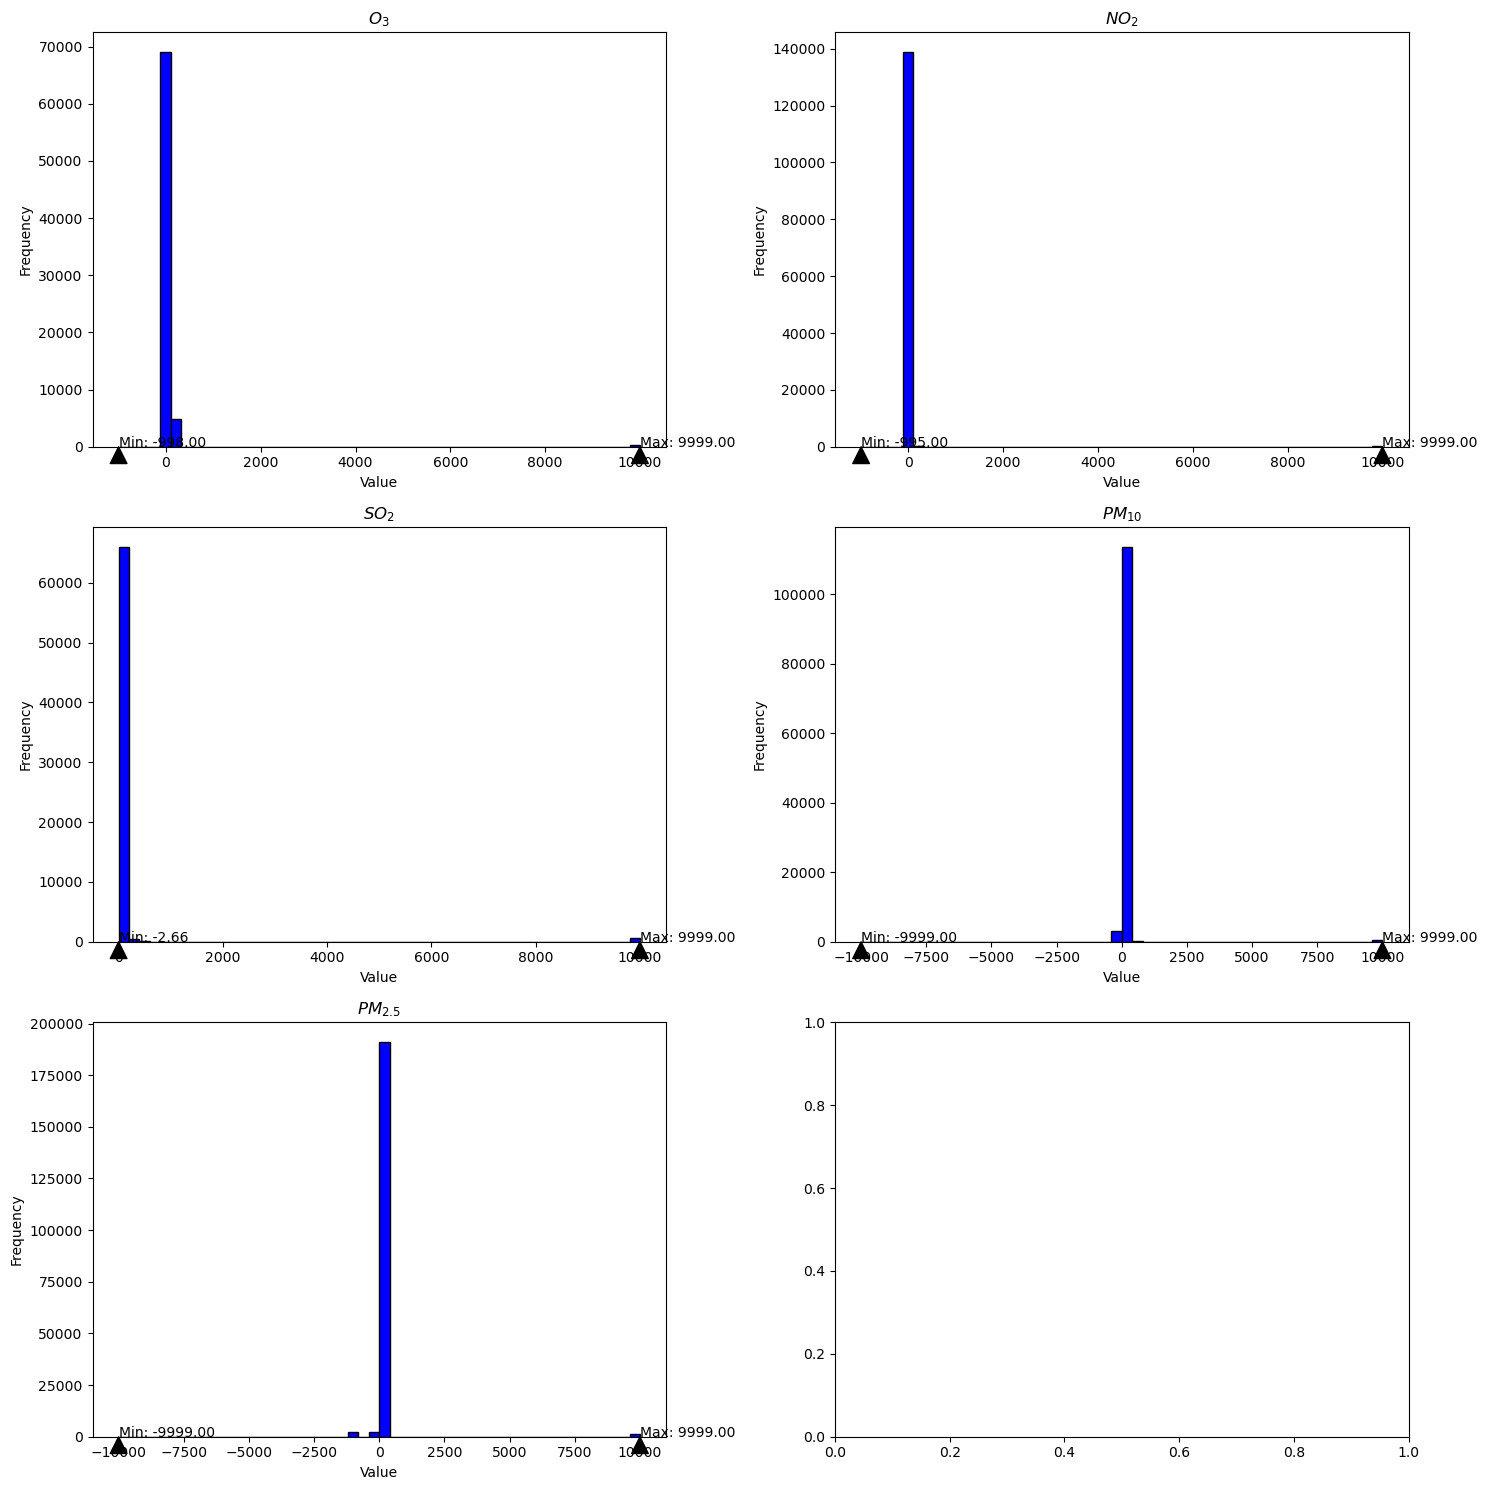

In [36]:
# Create histograms for each pollutant
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs = axs.flatten()

for i, (parameter, label) in enumerate(zip(pollutants, pollutant_labels)):
    ax = axs[i]
    df = data[parameter]
    values = df['value']
    
    ax.hist(values, bins=50, color='blue', edgecolor='black')
    ax.set_title(label)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    
    # Annotate min and max values
    min_val = values.min()
    max_val = values.max()
    ax.annotate(f'Min: {min_val:.2f}', xy=(min_val, 1), xytext=(min_val, 5),
                arrowprops=dict(facecolor='black', shrink=0.05))
    ax.annotate(f'Max: {max_val:.2f}', xy=(max_val, 1), xytext=(max_val, 5),
                arrowprops=dict(facecolor='black', shrink=0.05))

# Adjust layout and show plot
fig.tight_layout()
plt.show()

- maximum values for individual pollutants are ~1000
- some values off by quite a distant -> values at -9999 and +9999 are not physical and potentially represent missing values

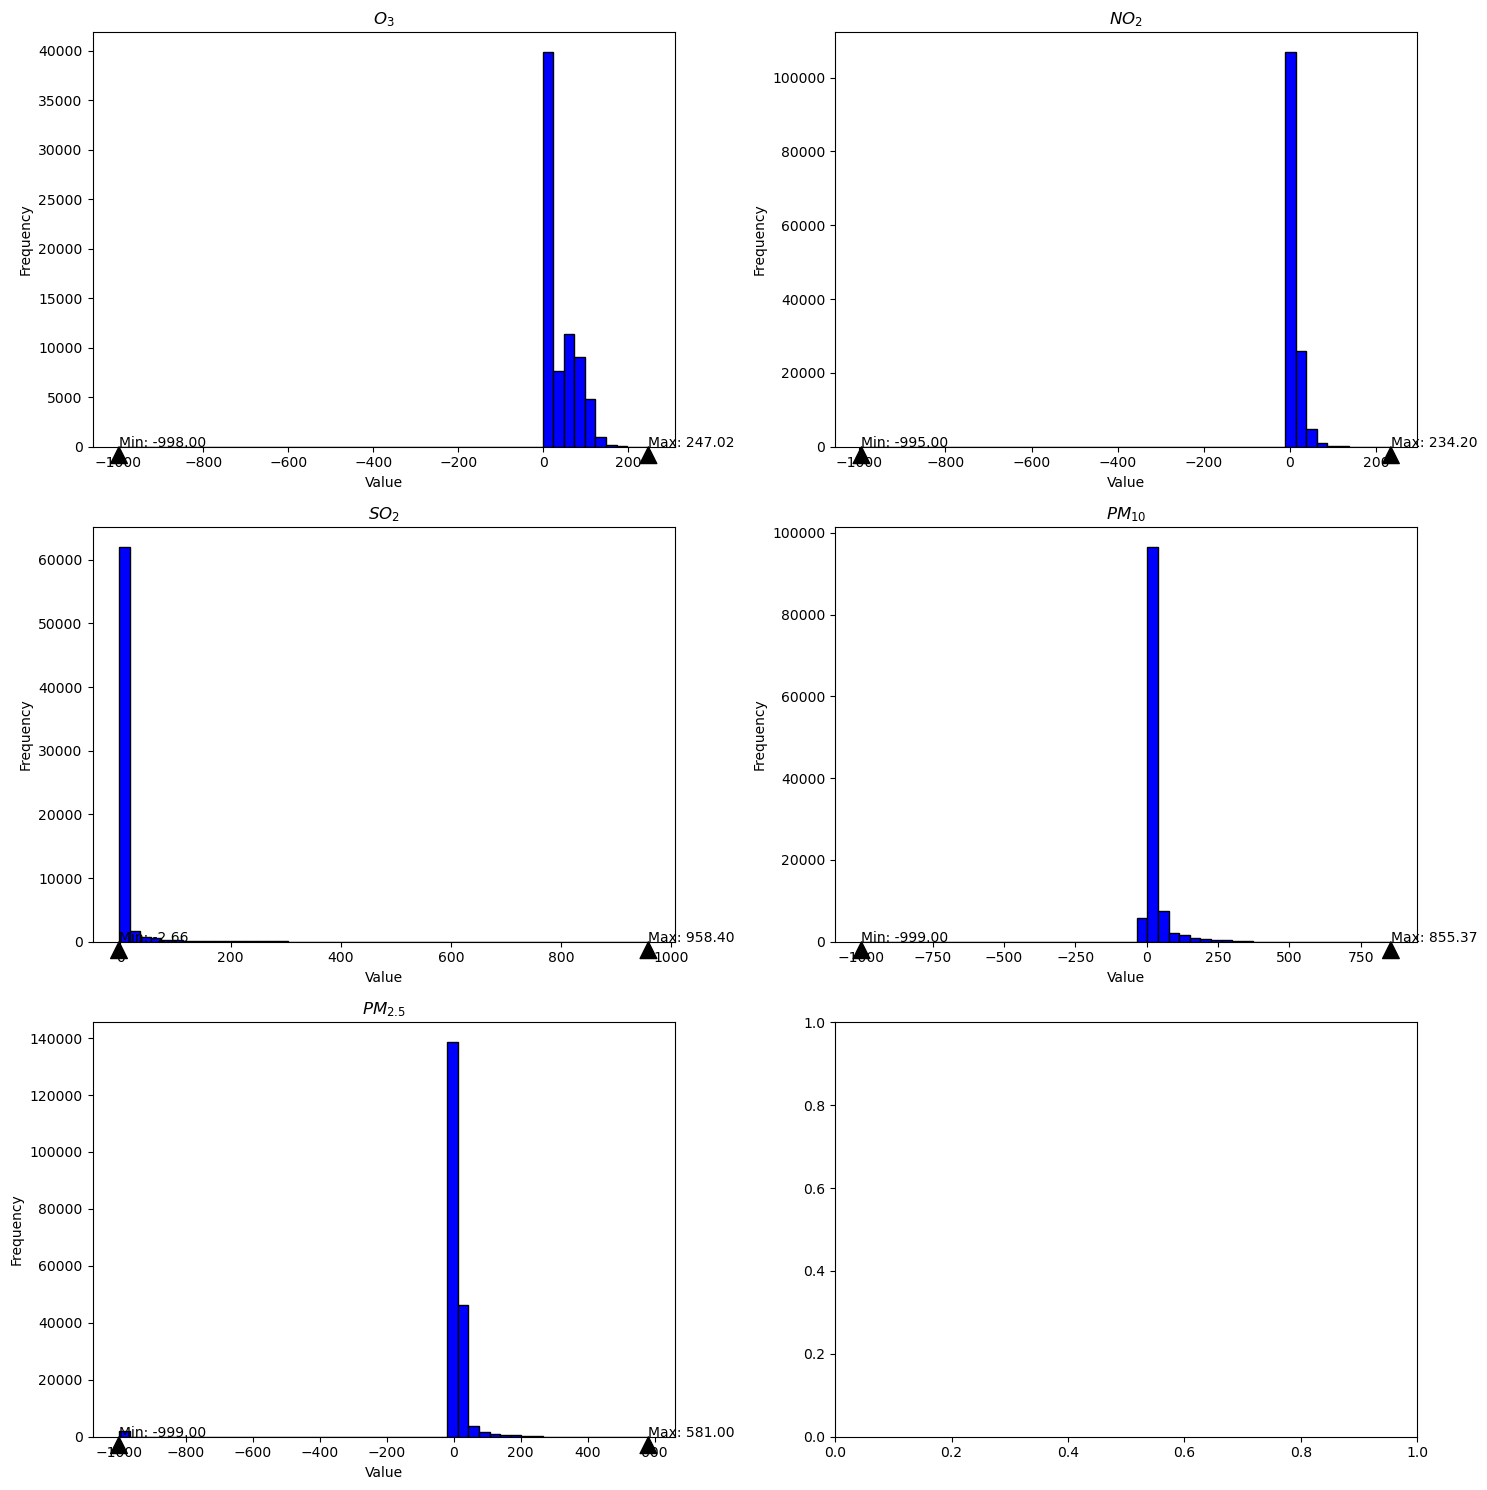

In [37]:
# Let's focus on the values between -1000 and 1000
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs = axs.flatten()

for i, (parameter, label) in enumerate(zip(pollutants, pollutant_labels)):
    ax = axs[i]
    df = data[parameter]
    values = df['value']
    
    # Filter values between -1000 and 1000
    filtered_values = values[(values >= -1000) & (values <= 1000)]
    
    ax.hist(filtered_values, bins=50, color='blue', edgecolor='black')
    ax.set_title(label)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    
    # Annotate min and max values
    min_val = filtered_values.min()
    max_val = filtered_values.max()
    ax.annotate(f'Min: {min_val:.2f}', xy=(min_val, 1), xytext=(min_val, 5),
                arrowprops=dict(facecolor='black', shrink=0.05))
    ax.annotate(f'Max: {max_val:.2f}', xy=(max_val, 1), xytext=(max_val, 5),
                arrowprops=dict(facecolor='black', shrink=0.05))

# Adjust layout and show plot
fig.tight_layout()
plt.show()

- some values slightly below 0 and then there is another group of values close to -1000
- slightly negative values can be expected due to sensor calibration, see: https://blog.quant-aq.com/why-is-my-air-quality-monitor-reporting-negative-values-and-what-can-i-do-about-it/
- values close to -1000 should be treated as missing values again

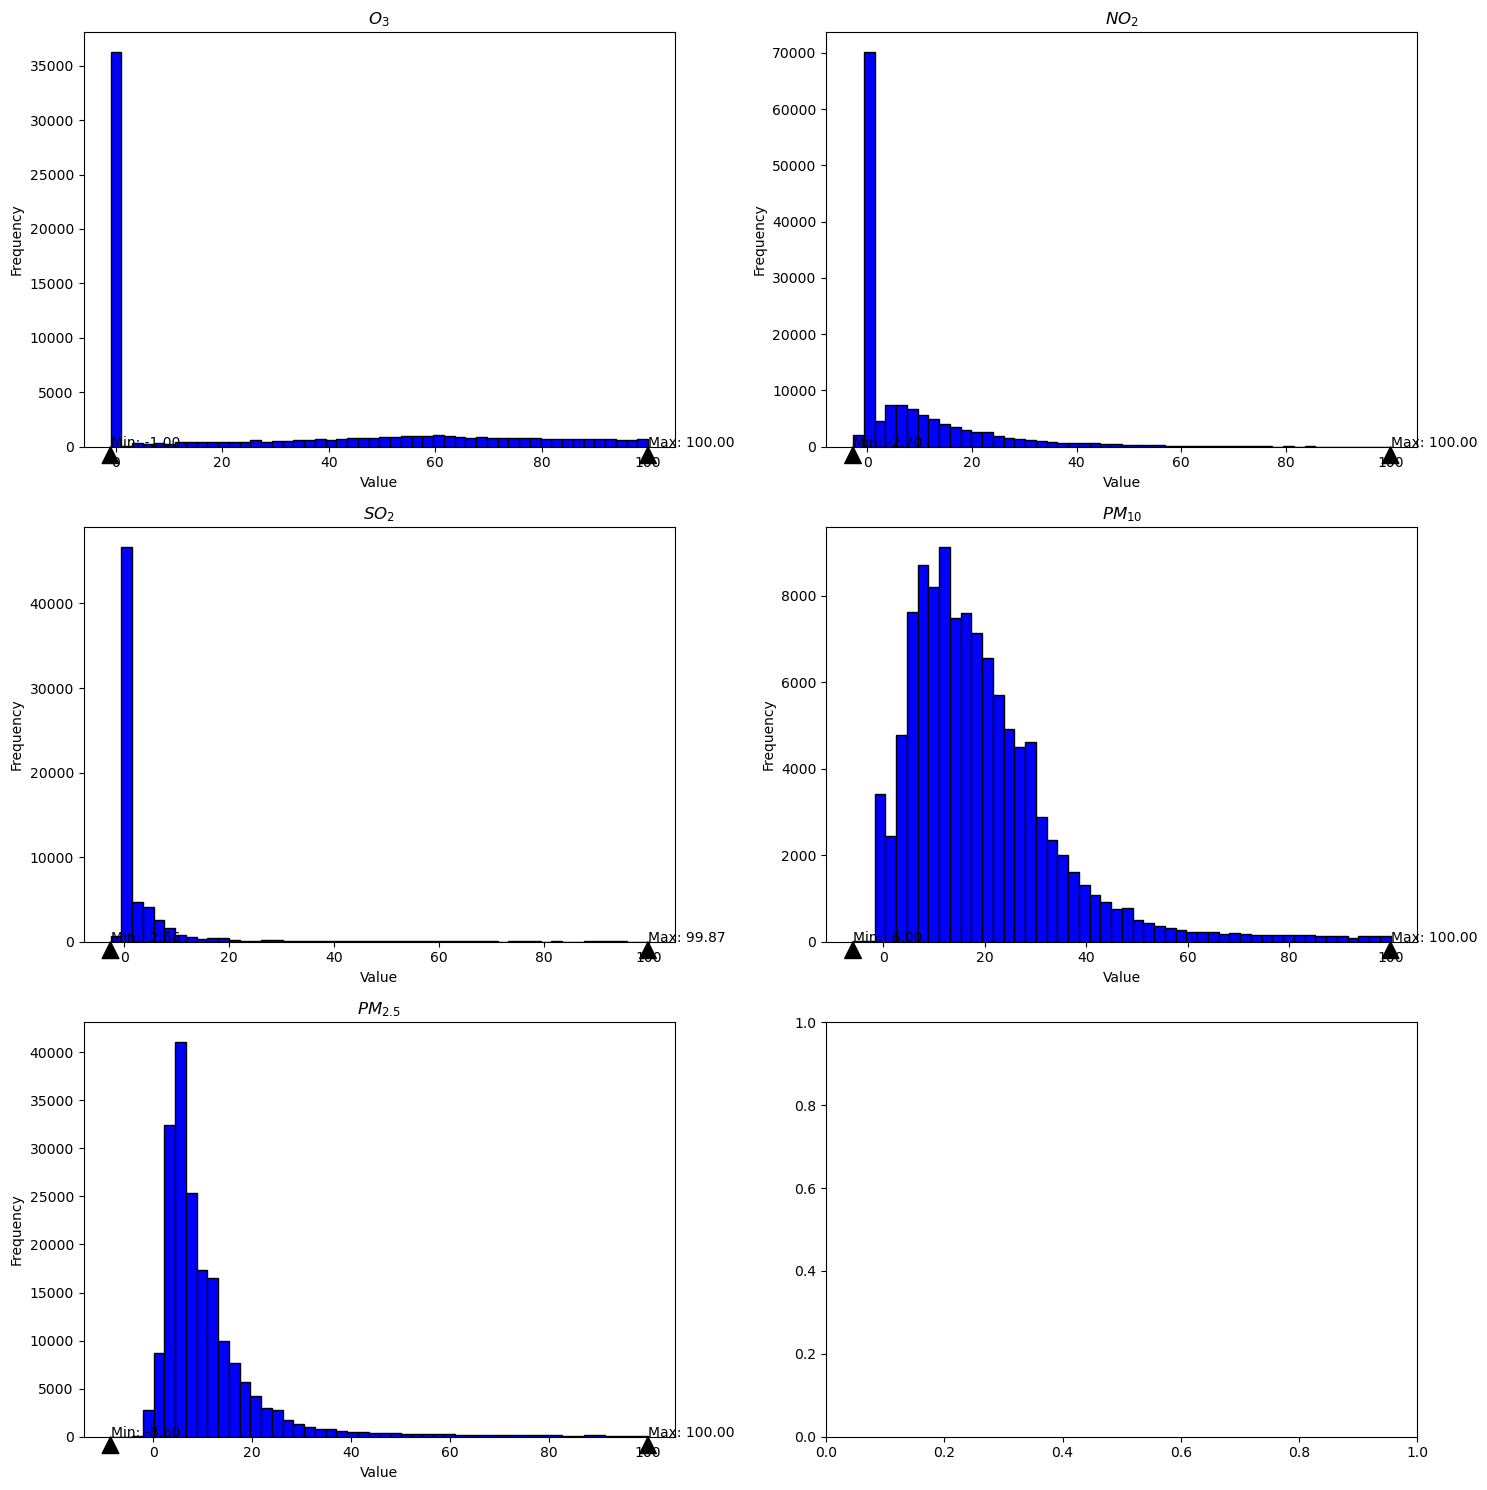

In [38]:
# Let's zoom in even further
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs = axs.flatten()

for i, (parameter, label) in enumerate(zip(pollutants, pollutant_labels)):
    ax = axs[i]
    df = data[parameter]
    values = df['value']
    
    filtered_values = values[(values >= -900) & (values <= 100)]
    
    ax.hist(filtered_values, bins=50, color='blue', edgecolor='black')
    ax.set_title(label)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    # ax.set_xlim(-10, 1)
    
    # Annotate min and max values
    min_val = filtered_values.min()
    max_val = filtered_values.max()
    ax.annotate(f'Min: {min_val:.2f}', xy=(min_val, 1), xytext=(min_val, 5),
                arrowprops=dict(facecolor='black', shrink=0.05))
    ax.annotate(f'Max: {max_val:.2f}', xy=(max_val, 1), xytext=(max_val, 5),
                arrowprops=dict(facecolor='black', shrink=0.05))
    

# Adjust layout and show plot
fig.tight_layout()
plt.show()

- further zoom in confirms this, there are no values between -500 and ~-10, so a sensible cutoff for realistic negative values could be -50
- O3, NO2 and SO2 show spikes at 0, how do we want to treat them?

### plot all available time series for all cities
Let's look at the time series data of the last 7 days for all returned locations within a 25 km search radius around the city center location. This will give us an idea about how many stations are available for each city, how homogenous the stations are within a single city and to check for data gaps and outliers. Cities with no data for any pollutant (see maps above) will be skipped.

In [39]:
# Read the CSV file to get the city names
with open(csv_file_path, mode="r", newline="") as csvfile:
    reader = csv.DictReader(csvfile)
    city_rows = list(reader)

for row in city_rows[:]:
    city_name = row["city"]
    country_name = row["country"]
    print(city_name)

    # Check if there is any data available for this city
    city_has_data = any(
        not data[parameter][data[parameter]["city"] == city_name].empty
        for parameter in pollutants
    )

    if not city_has_data:
        print(f"No data available for {city_name}. Skipping plot.")
        continue

    fig, axes = plt.subplots(
        nrows=len(pollutants), ncols=1, figsize=(15, 26), sharex=False
    )
    fig.suptitle(
        f"Time Series of Air Pollutants for {city_name} ({country_name})",
        fontsize=20,
        fontweight="bold",
        y=0.98,
    )

    for i, parameter in enumerate(pollutants):
        ax = axes[i]
        city_data = data[parameter][data[parameter]["city"] == city_name]

        # Ensure date_utc column is of datetime type
        city_data.loc[:, "date_utc"] = pd.to_datetime(city_data["date_utc"])

        # Sort city_data by date_utc in ascending order
        city_data = city_data.sort_values(by="date_utc")

        # Plotting each location individually
        for location in city_data["location_name"].unique():
            location_data = city_data[city_data["location_name"] == location]

            # Remove duplicate dates
            location_data = location_data.drop_duplicates(subset=["date_utc"])

            # Resample data to fill missing dates with NaN
            location_data = (
                location_data.set_index("date_utc")
                .resample("h")
                .asfreq()
                .reset_index()
                .infer_objects()
            )

            ax.plot(
                location_data["date_utc"],
                location_data["value"],
                marker="o",
                label=location[:15],
            )
        ax.axvline(x=end_date, color="k", linestyle="--", linewidth=1)
        ax.text(
            end_date,
            ax.get_ylim()[1],
            "query time",
            color="k",
            fontsize=12,
            rotation=90,
            verticalalignment="top",
        )

        ax.set_title(f"{pollutant_labels[i]}", fontsize=18)
        ax.set_ylabel("Value (µg/m³)")
        handles, labels = ax.get_legend_handles_labels()
        if labels:
            ax.legend(
                title="Station",
                bbox_to_anchor=(1.05, 1),
                loc="upper left",
                prop={"size": 8},
            )

        # Define the min and max for the x-axis
        plot_end_date = datetime.now().replace(
            hour=0, minute=0, second=0, microsecond=0
        ) + timedelta(days=1)
        start_date = plot_end_date - timedelta(days=7)

        # Manually set the min and max for the x-axis, ensuring it is linear
        ax.set_xlim(start_date, plot_end_date)
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m"))
        ax.xaxis.set_minor_locator(mdates.HourLocator(interval=6))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))

        # Rotate x-axis labels
        for label in ax.get_xticklabels():
            label.set_rotation(45)

    plt.xlabel("Date (UTC)")
    plt.subplots_adjust(left=0.05, right=0.8)
    plt.tight_layout(rect=[0, 0, 1.0, 0.97])

    filename = f"{ts_directory}/{city_name.replace(' ', '_')}_OpenAQ_individual_pollutants_{start_date.strftime('%Y%m%d')}_{end_date.strftime('%Y%m%d')}.pdf"
    plt.savefig(filename)
    # show plot inline
    # plt.show()
    plt.close(fig)

Dubai
No data available for Dubai. Skipping plot.
Abu Dhabi
Kabul
No data available for Kabul. Skipping plot.
Buenos Aires
Río Gallegos
No data available for Río Gallegos. Skipping plot.
Córdoba
No data available for Córdoba. Skipping plot.
Vienna
Salzburg
Perth
Darwin
No data available for Darwin. Skipping plot.
Adelaide
Sydney
Melbourne
Canberra
Cairns
Brisbane
Baku
Dhaka
Brussels
Sofia
Bahrain
No data available for Bahrain. Skipping plot.
La Paz
No data available for La Paz. Skipping plot.
Recife
No data available for Recife. Skipping plot.
São Paulo
Rio de Janeiro
Porto Alegre
No data available for Porto Alegre. Skipping plot.
Brasília
No data available for Brasília. Skipping plot.
Minsk
No data available for Minsk. Skipping plot.
Montreal
Toronto
Vancouver
Kinshasa
No data available for Kinshasa. Skipping plot.
Zurich
Geneva
Abidjan
Santiago
Shanghai
Chongqing
No data available for Chongqing. Skipping plot.
Beijing
Shenyang
Cartagena
No data available for Cartagena. Skipping plot.

/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_97205/1568377108.py:104: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 1.0, 0.97])


Glasgow
Belfast
Tbilisi
No data available for Tbilisi. Skipping plot.
Cayenne
Accra
Athens
Guatemala City
Hong Kong
Tegucigalpa
No data available for Tegucigalpa. Skipping plot.
Zagreb
Budapest
Jakarta
Dublin
Jerusalem
No data available for Jerusalem. Skipping plot.
Tel Aviv-Yafo
No data available for Tel Aviv-Yafo. Skipping plot.
New Delhi
Kolkata
Mumbai
Tehran
No data available for Tehran. Skipping plot.
Venice
Rome
Kingston
No data available for Kingston. Skipping plot.
Amman
Tokyo


/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_97205/1568377108.py:104: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1.0, 0.97])
/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_97205/1568377108.py:104: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1.0, 0.97])
/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_97205/1568377108.py:104: UserWarning: Glyph 20117 (\N{CJK UNIFIED IDEOGRAPH-4E95}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1.0, 0.97])
/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_97205/1568377108.py:104: UserWarning: Glyph 24066 (\N{CJK UNIFIED IDEOGRAPH-5E02}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1.0, 0.97])
/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_97205/1568377108.py:104: UserWarning: Glyph 26481 (\N{CJK UNIFIED IDEOGRAPH-6771}) missing fr

Osaka


/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_97205/1568377108.py:104: UserWarning: Glyph 22586 (\N{CJK UNIFIED IDEOGRAPH-583A}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1.0, 0.97])
/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_97205/1568377108.py:104: UserWarning: Glyph 24066 (\N{CJK UNIFIED IDEOGRAPH-5E02}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1.0, 0.97])
/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_97205/1568377108.py:104: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-5357}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1.0, 0.97])
/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_97205/1568377108.py:104: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1.0, 0.97])
/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_97205/1568377108.py:104: UserWarning: Glyph 33509 (\N{CJK UNIFIED IDEOGRAPH-82E5}) missing fr

Nairobi
Phnom Penh
No data available for Phnom Penh. Skipping plot.
Seoul


/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_97205/1568377108.py:104: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1.0, 0.97])
/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_97205/1568377108.py:104: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1.0, 0.97])
/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_97205/1568377108.py:104: UserWarning: Glyph 50669 (\N{HANGUL SYLLABLE YEOG}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1.0, 0.97])
/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_97205/1568377108.py:104: UserWarning: Glyph 49569 (\N{HANGUL SYLLABLE SONG}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1.0, 0.97])
/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_97205/1568377108.py:104: UserWarning: Glyph 45236 (\N{HANGUL SYLLABLE NAE}) missing from current font.
  plt.tight_la

Busan


/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_97205/1568377108.py:104: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1.0, 0.97])
/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_97205/1568377108.py:104: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1.0, 0.97])
/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_97205/1568377108.py:104: UserWarning: Glyph 54637 (\N{HANGUL SYLLABLE HANG}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1.0, 0.97])
/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_97205/1568377108.py:104: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1.0, 0.97])
/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_97205/1568377108.py:104: UserWarning: Glyph 52380 (\N{HANGUL SYLLABLE CEON}) missing from current font.
  plt.tight_layout

Kuwait City
Astana
Beirut
No data available for Beirut. Skipping plot.
Colombo
No data available for Colombo. Skipping plot.
Tripoli
No data available for Tripoli. Skipping plot.
Yangon
Ulaanbaatar
Cozumel
No data available for Cozumel. Skipping plot.
Mexico City
Acapulco
No data available for Acapulco. Skipping plot.
Monterrey
Guadalajara
Kuala Lumpur
No data available for Kuala Lumpur. Skipping plot.
Lagos
No data available for Lagos. Skipping plot.
Abuja
Managua
No data available for Managua. Skipping plot.
Amsterdam
Oslo
Kathmandu
Wellington
Auckland
No data available for Auckland. Skipping plot.
Muscat
No data available for Muscat. Skipping plot.
Panama City
No data available for Panama City. Skipping plot.
Lima
Manila
Quetta
No data available for Quetta. Skipping plot.
Karachi
Islamabad
Warsaw
San Juan
Lisbon
Asuncion
Doha
No data available for Doha. Skipping plot.
Bucharest
Belgrade
Saint Petersburg
No data available for Saint Petersburg. Skipping plot.
Moscow
No data available 

/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_97205/1568377108.py:104: UserWarning: Glyph 26032 (\N{CJK UNIFIED IDEOGRAPH-65B0}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1.0, 0.97])
/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_97205/1568377108.py:104: UserWarning: Glyph 21271 (\N{CJK UNIFIED IDEOGRAPH-5317}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1.0, 0.97])
/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_97205/1568377108.py:104: UserWarning: Glyph 24066 (\N{CJK UNIFIED IDEOGRAPH-5E02}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1.0, 0.97])
/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_97205/1568377108.py:104: UserWarning: Glyph 24215 (\N{CJK UNIFIED IDEOGRAPH-5E97}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1.0, 0.97])
/var/folders/lw/h5082w7d5vg_pk1wy7wg9mtc0000gq/T/ipykernel_97205/1568377108.py:104: UserWarning: Glyph 28129 (\N{CJK UNIFIED IDEOGRAPH-6DE1}) missing fr

Kyiv
Kampala
Washington
Miami
Atlanta
Dallas
Chicago
New York
Los Angeles
No data available for Los Angeles. Skipping plot.
San Francisco
Montevideo
No data available for Montevideo. Skipping plot.
Caracas
No data available for Caracas. Skipping plot.
Ho Chi Minh City
Hanoi
Johannesburg
No data available for Johannesburg. Skipping plot.
Cape Town
Harare
No data available for Harare. Skipping plot.
